In [130]:
# PDE: -u_xx - u_yy = f(x, y)  on  [0,1]^2
# BCs:
#   u(x, 0) = 0
#   n·∇u = 0  at x=0 and x=1   (Neumann)
#   u(x, 1) = cos(π x)

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as sla

In [132]:
def u_exact(x,y):
    return (np.sinh(np.pi*y)/np.sinh(np.pi)) * np.cos(np.pi*x)

def plot_field(x,y,u):
    fig, ax = plt.subplots(figsize=(6, 5))
    c = ax.pcolormesh(x, y, u, shading='auto', cmap='plasma')
    ax.set_aspect('equal')
    ax.set_axis_off()
    cb = fig.colorbar(c, ax=ax)
    cb.set_label("u")
    plt.savefig("u_fd.png")
    plt.show()

def gnorm(u, hx, hy):
    return np.sqrt(hx * hy * np.sum(u**2))


In [133]:
def laplace_finite_difference(nx, ny, hx , hy):

    N = ny * nx

    alpha = 1 / hx ** 2
    beta = 1 / hy ** 2

    def f_func(x, y):
        return 0.0

    A = sp.lil_matrix((N, N))
    b = np.zeros(N)

    # Fill matrix A and vector b
    for i in range(ny):
        for j in range(nx):
            k = i * nx + j
            b[k] = f_func(x1d[j], y1d[i])

            # --- x-direction discretization (only for interior nodes) ---
            if j != 0 and j != nx - 1:
                A[k, k - 1] += -alpha
                A[k, k] += 2 * alpha
                A[k, k + 1] += -alpha

            #  --- y-direction discretization (only for interior nodes) ---
            if i != 0 and i != ny - 1:
                A[k, k - nx] += -beta
                A[k, k] += 2 * beta
                A[k, k + nx] += -beta

    # Apply Dirichlet boundary conditions in the y-direction (vectorized)
    bottom = np.arange(nx)  # i = 0 boundary indices
    top = np.arange((ny - 1) * nx, ny * nx)  # i = ny-1 boundary indices

    # Bottom boundary: u(x, 0) = 0
    A[bottom, :] = 0
    A[bottom, bottom] = 1.0
    b[bottom] = 0.0

    # Top boundary: u(x, 1) = sin(pi*x)
    A[top, :] = 0
    A[top, top] = 1.0
    b[top] = np.sin(np.pi * x1d)

    # Apply Dirichlet boundary conditions in the x-direction (vectorized)
    left = np.arange(0, N, nx)  # j = 0 boundary indices
    right = np.arange(nx - 1, N, nx)  # j = nx-1 boundary indices

    # Left boundary: u(0, y) = 0
    A[left, :] = 0
    A[left, left] = 1.0
    b[left] = 0.0

    # Right boundary: u(1, y) = 0
    A[right, :] = 0
    A[right, right] = 1.0
    b[right] = 0.0

    # Solve the linear system
    u_vec = sla.spsolve(A.tocsr(), b)
    u = u_vec.reshape((ny, nx))



    # Return necessary variables for further analysis
    return A, b, u


Mesh Statistics
Total Nodes: 256
nx = 16.00000 and ny = 16.00000
hx = 0.06250 and hy = 0.06250


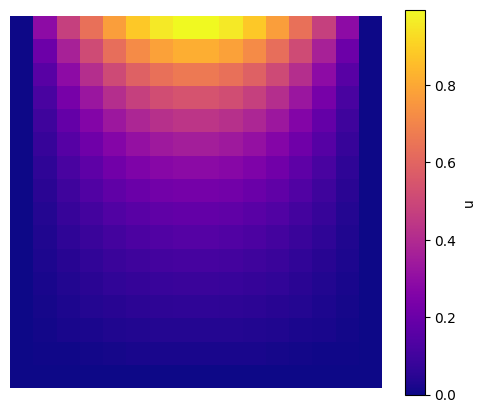

In [134]:
x_spacings = [16]
y_spacings = [16]

for nx,ny in zip(x_spacings, y_spacings):

    x1d, hx = np.linspace(0, 1, nx, endpoint=False, retstep=True)
    y1d, hy = np.linspace(0, 1, ny, endpoint=False, retstep=True)
    x1d += hx / 2
    y1d += hy / 2

    x, y = np.meshgrid(x1d, y1d)

    total_points = x.size
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    print("Mesh Statistics")
    print(f"Total Nodes: {total_points}")
    print(f"nx = {nx:.5f} and ny = {ny:.5f}")
    print(f"hx = {hx:.5f} and hy = {hy:.5f}")

    A, b, u = laplace_finite_difference(nx=nx, ny=ny, hx=hx, hy=hy)

    U = u_exact(x, y)

    plot_field(x,y,u)
    #plot_field(x,y,U)


In [135]:
F_ex = (A @ u.flatten() - b).reshape(u.shape)
print("Truncation:", gnorm(F_ex, hx, hy))


Truncation: 2.8709396599227175e-14


In [136]:
A_dense = A.toarray()
A_inv = np.linalg.inv(A_dense)
print("Norm of A^-1:", np.linalg.norm(A_inv))


Norm of A^-1: 8.723767841679132


In [137]:
print("Error:", gnorm(U - u, hx, hy))


Error: 0.40892397008475195
